In [ ]:
!pip install lightning-transformers

In [1]:
pwd

'C:\\Users\\asy10\\Desktop\\수업\\기계학습특강\\논문구현'

In [2]:
import json
import csv
 
# 일상생활및구어체_영한_train_set.json' 파일을 읽어서 melon.csv 파일에 저장
with open('./data/일상생활및구어체_영한_train_set.json', 'r', encoding = 'utf-8') as input_file, open('./data/train_set.csv', 'w', newline = '',encoding = 'utf-8') as output_file :
    data = json.load(input_file)

    f = csv.writer(output_file)
    
    # csv 파일에 header 추가
    f.writerow(['en', 'ko'])
    
    for line in data['data']:
        f.writerow([line['en'],line['ko']])

In [3]:
# 일상생활및구어체_영한_valid_set.json' 파일을 읽어서 melon.csv 파일에 저장
with open('./data/일상생활및구어체_영한_valid_set.json', 'r', encoding = 'utf-8') as input_file2, open('./data/test_set.csv', 'w', newline = '',encoding = 'utf-8') as output_file2 :
    data2 = json.load(input_file2)

    f = csv.writer(output_file2)
    
    # csv 파일에 header 추가
    f.writerow(['en', 'ko'])
    
    for line in data2['data']:
        f.writerow([line['en'],line['ko']])

In [3]:
#pip install pandas

In [4]:
import pandas as pd

p_data = pd.read_csv('./data/train_set.csv',encoding='utf-8')
test_data = pd.read_csv('./data/test_set.csv',encoding='utf-8')

In [7]:
p_data.head()

,en,ko
0,"I'm glad to hear that, and I hope you do consi...","그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다."
1,"I'm definitely thinking about it, but I have s...","확실히 생각하고 있습니다만, 몇 가지 여쭤보고 싶은 게 있어요."
2,"In today's world, one in every five families h...",오늘날 세계 5가구 중 1가구는 고양이나 개 또는 둘 다를 키우고 있습니다.
3,"When you tell them, we'll take care of their c...","그들에게 말하면, 저희가 그 아이들을 돌볼 것입니다."
4,"OK, how about for swimming?","좋아요, 수영은 어떤가요?"


In [5]:
len(p_data)

1200307

In [6]:
len(test_data)

150038

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time


from torchtext.legacy import data 
from konlpy.tag import Okt

tokenizer = Okt()

In [9]:
print(torch.__version__)

1.10.0


In [ ]:
#pip install konlpy

In [ ]:
#pip install spacy

In [ ]:
#conda install -c pytorch torchtext==0.11.0

In [10]:
def tokenize_kor(text):
    """한국어를 tokenizer해서 단어들을 리스트로 만듦"""
    return [text_ for text_ in tokenizer.morphs(text)]

def tokenize_en(text):
    """영어를 split tokenizer해서 단어들을 리스트로 만듦"""
    return [text_ for text_ in text.split()]

# 필드 정의(train)

SRC =data.Field(tokenize = tokenize_kor,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,lower = True)

TRG =data.Field(tokenize = tokenize_en,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,
                lower = True)

In [11]:
df_shuffled=p_data.sample(frac=1).reset_index(drop=True)
test_shuffled = test_data.sample(frac=1).reset_index(drop=True)

In [10]:
#pip install scikit-learn

In [12]:
df_shuffled.shape

(1200307, 2)

In [13]:
test_shuffled.shape

(150038, 2)

In [14]:
#train 
from sklearn.model_selection import KFold
df_ = df_shuffled[:100000]

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

for i,(trn_idx,val_idx) in enumerate(kf.split(df_['ko'])):
    trn = df_.iloc[trn_idx]
    val = df_.iloc[val_idx]

In [69]:

test_ = test_shuffled[:50000]


In [70]:
print('df size : ' ,len(df_))
print('trn size: ',len(trn))
print('val size: ',len(val))
print('val size: ',len(test_))

df size :  100000
trn size:  80000
val size:  20000
val size:  50000


In [61]:
path = './data/'
trn.to_csv(path + 'trn.csv',index = False)
val.to_csv(path + 'val.csv',index = False)
test_.to_csv(path + 'test.csv',index = False)

In [26]:
from torchtext.legacy.data import TabularDataset

train_data, validation_data =TabularDataset.splits(
     path='./data/', train='trn.csv',validation= 'val.csv', format='csv',
        fields=[('ko', SRC), ('en', TRG)], skip_header=True)

In [62]:
test_data = TabularDataset(path='./data/test.csv', format='csv',fields=[('ko', SRC), ('en', TRG)], skip_header=True)

In [46]:
print(vars(train_data.examples[30])['ko'])
print(vars(train_data.examples[30])['en'])

['i', 'want', 'to', 'be', 'away', 'from', 'everyone', 'so', 'that', 'i', 'can', 'think', 'about', 'some', 'issues', '.']
['이런저런', '생각을', '할', '수', '있도록', '모든', '사람과', '떨어져', '있고', '싶습니다.']


In [63]:
print(vars(test_data.examples[30])['ko'])
print(vars(test_data.examples[30])['en'])

['hello', ',', 'i', "'", 'm', 'bbb', 'company', "'", 's', 'aaa', '.']
['안녕하세요,', 'bbb', '회사', 'aaa입니다.']


In [135]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 12789
len(TRG): 34829


In [64]:
SRC.build_vocab(test_data, min_freq = 2)
TRG.build_vocab(test_data, min_freq = 2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 11153
len(TRG): 27099


In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 128

cuda:0


In [67]:
#데이터 로더와 유사한 기능

from torchtext.legacy.data import Iterator
train_iterator = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
valid_iterator = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
train_iterator = Iterator(dataset = test_data, batch_size = BATCH_SIZE)

In [71]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    """
    encoder와 decoder의 multi head attention 부분

    임베딩 된 sequence + positional encoding (or 이전 layer의 output) 을 이용해 
    self attention 을 수행하고 다음 layer(residual, normalization)로 보냄

    output: [batch size, seq_len, hidden_size] -> input과 차원이 같이야 여러 layer를 쌓을수 있음.
    """
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원 , 논문에서는 512
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수, 논문에서는 8
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원 -> 각 헤드의 차원 * 헤드의 hidden dim  = input hidden dim 이여야함, 논문에서는 512/8 = 64

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim) # 512,512

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query,key, value, mask = None):

        batch_size = query.shape[0]
        # query, key, value 행렬들의 dim을 query len(sequnece size) , embeding_size(hidden_dim) 으로 초기화 함 

        # query : [batch_size, query_len, hidden_dim]
        # key : [batch_size, query_len, hidden_dim]
        # value : [batch_size, query_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # multihead-attention레이어 안에서 scaled Dot-Product attetion 레이어에서 나온 Q,K,V 들을 concat함. 
        # concat한 것의 출력은 sequence_size x (n_heads x head_dim)
        # hidden_dim → n_heads X head_dim 형태로 변형
        
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        # QK^T / self.scale
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # 기울기 소실 방지

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]
        # hidden_dim → n_heads X head_dim 형태로 변형됨 

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

In [72]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

In [73]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim) # multi-head-attention레이어위에 norm 레이어 
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)


    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask) # 하나의 입력값을 통해 query, key, value 값 생성 , decoder는 다름.

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [74]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        #논문에서는 n_layers , 즉 레이어의 개수 6개 
        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)# positional encoding 
        # layer를 쌓음
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        # positional encoding 
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

In [75]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim) # 디코더의 첫 번째 어텐션 레이어 norm
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim) # 디코더의 두 번째 어텐션(인코더의 출력을 입력으로) 레이어 norm
        self.ff_layer_norm = nn.LayerNorm(hidden_dim) # 디코더의 feedforward layer norm 
        
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

In [76]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim) # postional encoding 

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [77]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [78]:
# 하이퍼 파라미터 설정
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [79]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [80]:
# 가중치 초기화
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(11153, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )


In [81]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [82]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):

        src = batch.ko.to(device)
        trg = batch.en.to(device)


        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [83]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0


    # 전체 평가 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.ko.to(device)
        trg = batch.en.to(device)

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [84]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [113]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
import copy 

best_val_loss = float('inf')
epochs = 200
best_model = None

train_losses = []
valid_losses = [] 


for epoch in range(1, epochs + 1):

    epoch_start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    

    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    
    val_ppl = math.exp(valid_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | ' f'valid loss {valid_loss:5.2f} |  train loss | {train_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_en_to_ko.pt')
        best_model = copy.deepcopy(model)

    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 34.31s | valid loss  8.88 |  train loss |  4.97 | valid ppl  7154.94
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 34.76s | valid loss  8.87 |  train loss |  4.97 | valid ppl  7120.78
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 34.61s | valid loss  8.87 |  train loss |  4.96 | valid ppl  7134.96
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 34.51s | valid loss  8.86 |  train loss |  4.97 | valid

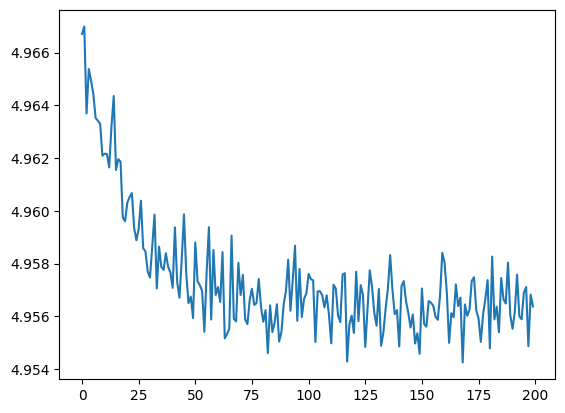

In [114]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [109]:
test_loss = evaluate(best_model, valid_iterator, criterion)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  8.40 | test ppl  4433.05


In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_en_to_ko.pt')
        best_model = copy.deepcopy(model)

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

In [36]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):        
        tokens = [text_ for text_ in tokenizer.morphs(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = ['<sos>'] + tokens + ['<eos>']

    # text -> token
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi['<sos>']]

    # 한 단어씩 생성
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [47]:
example_idx = 10

src = input()

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)
# trg: [batch_size, trg_len, hidden_dim]
# attention: [batch_size, n_heads, trg_len, src_len]
print('')
print("모델 번역 결과:", " ".join(translation))
print("attention : ", attention.shape)

 I think it startd from that time.



모델 번역 결과: 그 시기에 그렇게 하는 것 같네요. <eos>
attention :  torch.Size([1, 8, 7, 10])
